# 3-6. 프로젝트: 고양이 수염 스티커 만들기 🐈

## Step 1. open cv 및 필요한 라이브러리 불러오기

In [256]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## Step 2. 이미지 준비하기 및 RGB로 출력하기

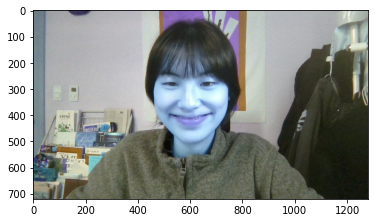

In [257]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_weight = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

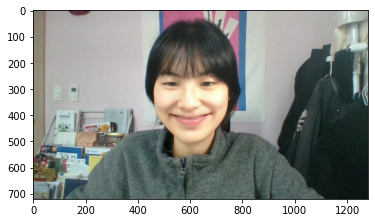

In [258]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

한번에 bgr을 rgb로 바꿔서 출력하는 코드를 작성하고 싶었는데 뭐가 문제지...?

In [259]:
# my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
# img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# img_show = img_rgb.copy()      # 출력용 이미지를 따로 보관합니다
# plt.imshow(img_rgb)
# plt.show()

왜 grayscale로 해보려고 할 때마다 dead kernel이 뜨지?.........
--> 추측컨대... destroyAllWindows() 얘 때문이다....

In [260]:
# my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
# image = cv2.imread(my_image_path)
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
# cv2.imshow('Original image',image)
# cv2.imshow('Gray image', gray)
  
# cv2.waitKey(0)
# cv2.destroyAllWindows()

## Step 3. 얼굴 검출 & 랜드마크 검출 하기

In [261]:
# hog detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()

In [262]:
# detector_hog를 이용해서 얼굴의 bounding box를 추출합니다.
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print(dlib_rects)

rectangles[[(455, 206) (776, 527)]]


이미지 피라미드를 활용해 찾은 얼굴을 화면에 출력

rectangles[[(455, 206) (776, 527)]]


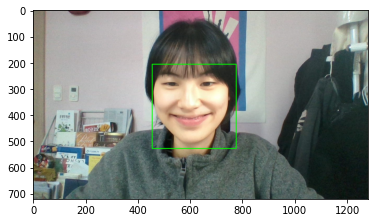

In [263]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

dlib detector 는 dlib.rectangles 타입의 객체를 반환합니다.   
dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어져 있습니다.

[dlib.rectangles](http://dlib.net/python/index.html#dlib.rectangles)

### face landmark localization 
- face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용
- Object keypoint estimation 알고리즘: 객체 내부의 점을 찾는 기술

In [264]:
# 저장되어 있는 landmark 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [265]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


랜드마크를 얼굴에 출력해보기

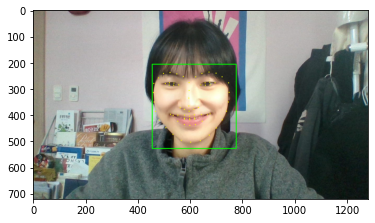

In [266]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 4. 스티커 적용 위치 확인하기
-  landmark를 사용해서 계산 필요

좌표 확인하기

In [267]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    
    print("(x, y) : ({}, {})".format(x, y))
    print("(w, h) : ({}, {})".format(w, h))

(595, 365)
(x, y) : (595, 365)
(w, h) : (322, 322)


준비해 둔 스티커 이미지를 읽어서 적용하기

In [268]:
# 스티커 이미지를 불러옵니다
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) 

이미지 resize 하기

In [269]:
img_sticker = cv2.resize(img_sticker, (w, h))
print (img_sticker.shape)

(322, 322, 3)


(322, 322, 3)


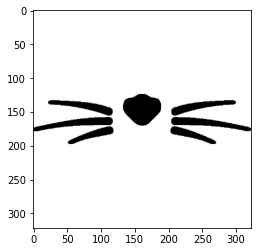

In [270]:
# RGB 이미지로 바꾸기
img_sticker_rgb = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB)
plt.imshow(img_sticker_rgb)
print (img_sticker_rgb.shape)

ndarray는... 
- y축이 아래로 가면 더하고(+), 올라가면 빼준다(-)
- x축은 원래 아는 그대로..

In [271]:
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print("(x, y) : ({}, {})".format(refined_x, refined_y))

(x, y) : (434, 204)


 원본 이미지의 범위를 벗어난 스티커 부분 crop -> 고양이 수염에는 해당 無

In [272]:
# if refined_x < 0: 
#     img_sticker = img_sticker[:, -refined_x:]
#     refined_x = 0
# if refined_y < 0:
#     img_sticker = img_sticker[-refined_y:, :]
#     refined_y = 0

# print("(x, y) : ({}, {})".format(refined_x, refined_y))

## Step 5. 스티커 적용하기
- 스티커 이미지에서 사용할 부분은 (0 이 아닌) 색이 있는 부분을 사용합니다. 
- np.where를 통해 img_sticker가 0이 아닌 부분(검정): img_sticker, 0인 부분: sticker_area를 사용합니다. 
- img_show 에 다시 적용

In [273]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker, sticker_area).astype(np.uint8)

In [274]:
print(sticker_area.shape)

(322, 322, 3)


In [275]:
img_sticker.shape

(322, 322, 3)

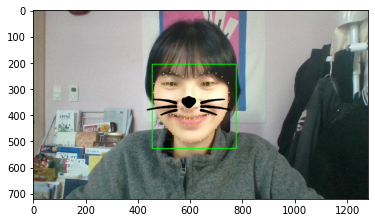

In [276]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

bounding box와 landmark 제거하기

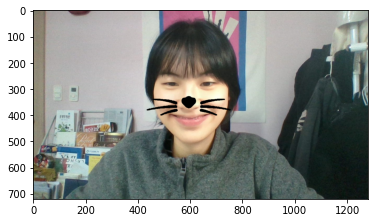

In [277]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

스티커를 조금 더 자연스럽게 만들기 - cv2.addWeighted() 메서드 사용하기!

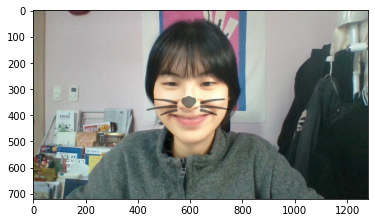

In [278]:
sticker_area = img_weight[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_weight[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_weight, cv2.COLOR_BGR2RGB))
plt.show()

## Step 5. 문제점 찾아보기

In [290]:
def put_on_sticker(img_path):
    #이미지 로드
    my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/' + img_path
    img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
    img_bgr = cv2.resize(img_bgr, (640, 360)) 
    img_show = img_bgr.copy()
    
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

    #detector를 이용해 얼굴의 bounding box 추출
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1) 
    
    # 얼굴 검출
    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    
    #저장한 landmark 모델 불러오기

    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)
    
    
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    for landmark in list_landmarks:
        for idx, point in enumerate(list_points):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)    
    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)   
    
    #스티커 적용위치
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        # whiskers center index : 33
        x = landmark[30][0]
        y = landmark[30][1] 
        w =  dlib_rect.width()
        h =  dlib_rect.width()
    
    
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    
    # top, left 위치 설정
    refined_x = x - w//2 # left
    refined_y = y - h//2   # top

    
    sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[1], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

- 더 가깝고 얼굴 각도 다른 사진

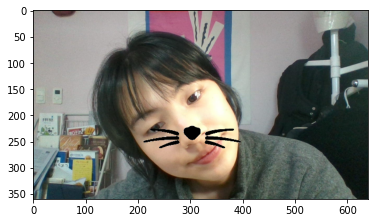

In [291]:
put_on_sticker('near.png')

- 멀리서 찍은 사진

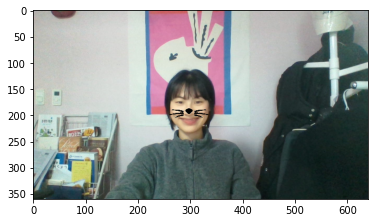

In [292]:
put_on_sticker('far.png')

`- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?`  
    * 스티커의 각도가 변하지 않아서 문제... rectangle 설정부터 다시해서 얼굴이 기운 정도에 맞춰 스티커도 rotate할 수 있도록 구현해야합니다.  
    
`- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?`  
    * 너무 멀리 가면 얼굴 인식이 안될 수도... 누워서 하면 얼굴 위치와 눈, 코, 입 등 이목구비를 잡아내기 어려울 수도 있을거라고 생각합니다.   
    
`- 실행 속도가 중요할까요?`  
    * 지금은 이미지 수가 몇개 없기 때문에 괜찮지만, 개수가 많아지면 속도도 당연히 중요해질 것으로 생각됩니다. 물론 딥러닝 모델이므로 많이 학습시킬수록 속도도 빨라질 것이라 생각합니다.   
    
`- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?`  
    * 정확도는 매우 중요합니다. 스티커가 있어야 할 곳에 적용되게 하는 것이 이 앱의 존재 이유인데, 이를 제대로 하지 못한다면 이 스티커 앱의 존재 목적이 사라지는 것입니다.   
    * 얼굴 각도에 따라 스티커를 빠르고 정확하게 적용시키는 것이 앱의 경쟁력이 될 것입니다. 

## 회고

1. 처음에 ndarray가 원래 좌표와는 다른 +,-의 개념을 갖고 있다는 것을 몰라서 이해하려고 애쓰는데 한참이 걸렸습니다. 그래도 결국엔 그래프를 유심히 본 결과 x축은 그대로지만, y축은 아래로 갈수록 숫자가 커진다는 사실을 발견하여 이해할 수 있었습니다.
2. 다른 부분들은 lms를 자세히 살펴보면 알 수 있었는데(ex. 고양이 수염 배경 지우기 등), cv2.addWeighted()로 투명도를 적용하는 것에 있어서는 어디에 이걸 추가해야하고 파라미터로 어떤 값들을 받아야 하는지가 명확하게 이해하기 어려웠습니다.
3. 문제점에 나와있는 얼굴 각도가 다를 때 스티커가 dynamic하게 같이 각도를 바꿔주면 좋겠는데 이런 코드를 작성하기에는 한계가 있음을 느끼며,,, 더 열심히 (얼마나 열심히...?) 공부해야함을 느낄 수 있었습니다...


**대충 보고 넘기면 괜찮지만, 꼼꼼히 보려다보니 오래걸리고 점점 프로젝트가 어려워지는 것 같네요 휴우.. 😟**